In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%run './functions_needed.ipynb'
file_path = Path(direcroy_path) / Path('preprocessed_fp2.csv')
df = pd.read_csv(file_path)


In [2]:
df.set_index('Gene names',inplace=True)
#ref_meta = df.filter(regex='^Identification metadata 9|^Identification metadata 10|^Identification metadata 11')
ref_meta = df.filter(regex='^Identification metadata 9')#df = df.filter(regex='^Reporter intensity corrected 10|^Reporter intensity corrected 11|^Reporter intensity corrected 9')
df = df.filter(regex='^Reporter intensity corrected 9')
df = df.loc[:,~df.columns.str.contains('Batch16')] # batch 16 was removed as

# CV calculations

In [3]:
def get_final_cv_df(df:pd.DataFrame,removing_cutoff=0.6): 
    df = protein_remover_by_sparcity(df,minimum_samples_inside=math.floor(removing_cutoff*len(df.columns)))
    # take only channel 9 put them togeter and then filter 0.95 of the data
    # remove the outliar for 
    df['Proteins_names'] = df.index
    melted_df = pd.melt(df,id_vars=['Proteins_names'])
    melted_df["Batch_name"] = melted_df.variable.apply(lambda x:x.split('_')[1])
    melted_df['Batch_name'] = melted_df.Batch_name.str.replace("Batch",'')
    melted_df.Batch_name = melted_df.Batch_name.astype('int')
    melted_df1 = melted_df[melted_df.Batch_name < 73]
    #melted_df2 = melted_df[melted_df.Batch_name > 75]
    melted_df1.value = np.power(10,melted_df1.value)
    #melted_df2.value = np.power(10,melted_df2.value)
    cv_df_1 = get_cv_from_melted_df(melted_df1)  # untill batch 73  QC1
    #cv_df_2 = get_cv_from_melted_df(melted_df2)  # from batch 76 QC2
    return cv_df_1

all_Cvs = {x:get_final_cv_df(df,x) for x in [0.6,0.7,0.8,.95]}

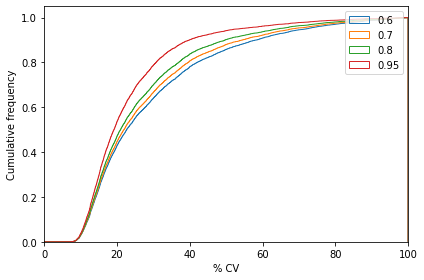

In [4]:
for key in all_Cvs.keys():
    plt.hist(all_Cvs[key]['cv']*100, cumulative=True, bins=np.linspace(0,100,1000), histtype='step', density=True, label=key)

#plt.hist(final_df['cv_qc1']*100, cumulative=True, bins=np.linspace(0,100,1000), histtype='step', density=True, label='QC76-130')
plt.legend()
plt.xlim([0, 100])
plt.xlabel('% CV')
plt.ylabel('Cumulative frequency')
plt.tight_layout()
plt.savefig(f'{direcroy_path}/CV_plot_QC_ref_channels.svg',dpi=300)

In [9]:
all_Cvs[0.95].to_excel(f'{direcroy_path}/CVS_0.95.xlsx')

In [10]:
direcroy_path

'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT'

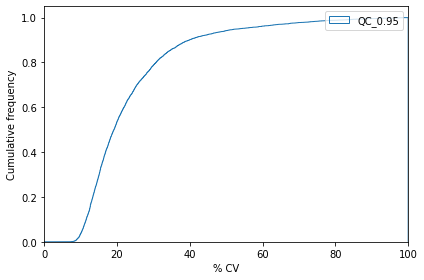

In [5]:

plt.hist(all_Cvs[0.95]['cv']*100, cumulative=True, bins=np.linspace(0,100,1000), histtype='step', density=True, label='QC_0.95')

plt.legend()
plt.xlim([0, 100])
plt.xlabel('% CV')
plt.ylabel('Cumulative frequency')
plt.tight_layout()
plt.savefig(f'{direcroy_path}/CV_plot_QC_ref_channels_0.95.svg',dpi=300)

# Correlation calculation between RNA and proteins

In [6]:
meta_df = pd.read_excel(patietns_meta_data)
intensity_meta = load_intensity_meta_data(Path(direcroy_path)/Path(PREPROCESSED_FP_INTENSITY),'Gene names')
RNA_failed_patients = meta_df['Sample name'][meta_df['RNA QC issue'] == 'x'].tolist()
#  full proteome_z_scores
Z_SCORES_df_proteome = pd.read_csv(Path(direcroy_path)/Path(Z_SCORES_PATH),sep='\t')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.set_index('Gene names')
Z_SCORES_df_proteome = Z_SCORES_df_proteome.filter(regex=REGEX)
# there is no protein grouping at transcriptome level we unnest the protein groups also for protein data
Z_SCORES_df_proteome = unnest_proteingroups(Z_SCORES_df_proteome)
Z_SCORES_df_proteome.columns = Z_SCORES_df_proteome.columns.str.replace('zscore_','')

# transcriptome_z_scores
transcripts_z_scores = pd.read_csv(transcripts_path)
transcripts_z_scores = transcripts_z_scores.set_index('genes')
transcripts_z_scores =  transcripts_z_scores.filter(regex=Z_SCORE_REGEX)
transcripts_z_scores.columns = transcripts_z_scores.columns.str.replace(' Z-score','')

protein_list = intersection(transcripts_z_scores.index.tolist(),Z_SCORES_df_proteome.index.tolist())
intersecting_patients = intersection(transcripts_z_scores.columns.tolist(),Z_SCORES_df_proteome.columns.tolist())

intersecting_patients = [x for x in intersecting_patients if x not in  RNA_failed_patients]
Z_SCORES_df_proteome = Z_SCORES_df_proteome[intersecting_patients]
transcripts_z_scores = transcripts_z_scores[intersecting_patients]
correlation_df = pd.DataFrame(protein_list,columns=['protein'])
correlation_df['correlation'] = None
correlation_df['num_patients'] = None
correlation_df['median_peptides'] = None

for i in range(len(correlation_df)):
    protein_correlaiton, num_patientes = get_correlation(correlation_df['protein'][i],Z_SCORES_df_proteome,transcripts_z_scores)
    correlation_df['correlation'][i] = protein_correlaiton
    correlation_df['num_patients'][i] = num_patientes
    try:
        correlation_df['median_peptides'][i] = get_pep_number_from_protein_name(intensity_meta,correlation_df['protein'][i])['num_pep'].median()
    except:
        pass
    
correlation_df = correlation_df.set_index('protein')

basket_annotation_df = pd.read_excel(basket_annotation_path)
correlation_df['basket_annotation'] = ''
for i in range(len(correlation_df)):
    correlation_df['basket_annotation'][i] = ';'.join(basket_annotation_df['BASKET'][basket_annotation_df["GENE NAME"].isin([correlation_df.index[i]])].unique().tolist())

correlation_df = correlation_df.dropna(subset='correlation')
correlation_df.to_excel(f'{direcroy_path}/correlation_all_proteins_RNA_failed_removed.xlsx')

reading /media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT/preprocessed_fp.csv
Intensity meta_data loaded


# Median of Identified number peptides for each protein

In [7]:
correlation_df['protein'] = correlation_df.index
correlation_df['Gene names'] = correlation_df.index
qc_df1= all_Cvs[0.95][['Gene names','cv']]
qc_df1.columns = ['Gene names','cv_qc']
#qc_df2= cv_df_2[['Gene names','cv']]
#qc_df2.columns = ['Gene names','cv_qc2']
final_df = correlation_df.merge(qc_df1,on='Gene names')
#final_df = final_df.merge(qc_df2,on='Gene names')
qc_df1.dropna(subset='cv_qc',inplace=True)
#qc_df2.dropna(subset='cv_qc2',inplace=True)
qc1_list = qc_df1['Gene names'].tolist()
#qc2_list = qc_df2['Gene names'].tolist()
#qc_expressed = intersection(qc1_list,qc2_list)
final_df['ref_channel_median_num_pep'] = None
for i in range(len(final_df)):
    protein_name = final_df['Gene names'][i]
    final_df['ref_channel_median_num_pep'][i] = get_pep_number_from_protein_name(ref_meta,protein_name)['num_pep'].median()
final_df.to_excel(f'{direcroy_path}/correlation_cv_num_peptides.xlsx')